In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
import math
import json

from pdf2image import convert_from_path
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
#### 최신버전
def convert_pdf_folder_to_images(pdf_folder, output_folder, chk = False):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(pdf_folder):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(pdf_folder, filename)
            images = convert_from_path(pdf_path)
            base_filename = os.path.splitext(filename)[0]
            
            for page_num, img in enumerate(images):
                if page_num == 0:
                    left_num = len(images)*2
                    right_num = 1
                else:
                    left_num = right_num + 1
                    right_num = left_num + 1
                    
                output_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}.jpg")
                img.save(output_path, 'JPEG')
                
                if chk:
                    width, height = img.size
                    print(width, height)
                    # width -= 20
                    # height -= 20
                    # left_half = img.crop((20, 20, width // 2, height))
                    # right_half = img.crop((width // 2, 20, width, height))
                    crop_size = 30
                    left_half = img.crop((crop_size, crop_size, int((width/2)-crop_size), height-crop_size))
                    right_half = img.crop((int((width/2)+crop_size), crop_size, width-crop_size, height-crop_size))
                else:
                    width, height = img.size
                    left_half = img.crop((0, 0, width // 2, height))
                    right_half = img.crop((width // 2, 0, width, height))
                    
                # left_half_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}_left.jpg")
                # right_half_path = os.path.join(output_folder, f"{base_filename}_page_{page_num + 1}_right.jpg")
                left_half_path = os.path.join(output_folder, f"{base_filename}_{left_num}.jpg")
                right_half_path = os.path.join(output_folder, f"{base_filename}_{right_num}.jpg")
                
                left_half.save(left_half_path, 'JPEG')
                right_half.save(right_half_path, 'JPEG')
                
# pdf_folder = './scan/datas/pdf'  # PDF 파일이 있는 폴더 경로
# output_folder = './scan/datas/pdf/divided/t2'  # 출력 이미지 파일을 저장할 폴더 경로
pdf_folder = './scan/datas/pdf/'  # PDF 파일이 있는 폴더 경로
output_folder = './scan/datas/pdf/divided/tem'  # 출력 이미지 파일을 저장할 폴더 경로

convert_pdf_folder_to_images(pdf_folder, output_folder, chk = False) # chk : True -> 마킹된 검사지 

In [ ]:
#### 최신버전
def is_square(cnt, min_area, max_area):
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    
    # 정사각형은 꼭지점이 4개여야 함
    if len(approx) != 4:
        return False

    # 각도와 비율 체크
    for i in range(4):
        pt1 = approx[i][0]
        pt2 = approx[(i + 1) % 4][0]
        pt3 = approx[(i + 2) % 4][0]
        
        vec1 = pt2 - pt1
        vec2 = pt3 - pt2
        
        dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
        magnitude1 = np.sqrt(vec1[0]**2 + vec1[1]**2)
        magnitude2 = np.sqrt(vec2[0]**2 + vec2[1]**2)
        
        cos_angle = dot_product / (magnitude1 * magnitude2)
        angle = np.arccos(cos_angle) * (180 / np.pi)
        
        if angle < 80 or angle > 100:  # 각도가 직각에 가까운지 체크
            return False
    
    # 가로와 세로의 길이가 거의 같은지 확인
    x, y, w, h = cv2.boundingRect(approx)
    if abs(w - h) > min(w, h) * 0.1:  # 정사각형 비율이 아닌 경우 제외
        return False
    
    area = cv2.contourArea(cnt)
    if area < min_area or area > max_area:
        return False

    return True

def draw_contours(image_folder, output_folder, min_area=100, max_area=1000):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    cut_img_dict = dict()
    for filename in os.listdir(image_folder):
        if (filename.endswith('.jpg')) and ("_page" not in filename):
            # if "MIT" not in filename:
            #     continue
            # print(filename)
            for_path = filename.replace(".jpg", "")
            splited_for_path = for_path.split("_")
            page_num = splited_for_path[-1]
            pj_name = "_".join(splited_for_path[:-1])
            if pj_name not in cut_img_dict:
                cut_img_dict[pj_name] = []
                
            image_path = os.path.join(image_folder, filename)
            img = cv2.imread(image_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (7, 7), 0)

            # 경계 검출 (Canny Edge Detection)
            edges = cv2.Canny(blurred, 50, 100) # 50 100

            # 윤곽선 검출
            contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # 사각형 및 크기 필터링
            rectangles = [cnt for cnt in contours if is_square(cnt, min_area, max_area)]
            
            # cv2.drawContours(img, rectangles, -1, (0, 0, 255), 5)
            # plt.figure(figsize=(20, 20))
            # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.show()
            
            rectangles = rectangles[:2] + rectangles[-2:]
            # 원본 이미지에 윤곽선 그리기
            # x 좌표와 y 좌표가 가장 작은 점이 좌상단 (top-left).
            # x 좌표는 크지만 y 좌표가 작은 점이 우상단 (top-right).
            # x 좌표는 작지만 y 좌표가 큰 점이 좌하단 (bottom-left).
            # x 좌표와 y 좌표가 모두 큰 점이 우하단 (bottom-right).
            cut_xy = []
            for rdx, rect in enumerate(rectangles):
                x, y, w, h = cv2.boundingRect(rect)
                if rdx == 0: # 우하단
                    cut_xy += [x + w]
                    cut_xy += [y + h]
                if rdx == 3: # 좌상단
                    cut_xy = [x, y] + cut_xy
                # cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 5)
            # cut_img_dict[filename]=cut_xy[:2]
            cut_img_dict[pj_name].append(cut_xy[:2])
            cut_xy = tuple(cut_xy)
            img = img[cut_xy[1]:cut_xy[3], cut_xy[0]:cut_xy[2]]
            # 결과 이미지 저장
            # result_image_path = os.path.join(output_folder, f"square_{filename}")
            result_image_path = os.path.join(output_folder, f"{filename}")
            cv2.imwrite(result_image_path, img)
            # cropped_image.save(result_image_path)
    
    return cut_img_dict

# 사용 예시
image_output_folder = './scan/datas/pdf/divided/tem'
contour_output_folder = './scan/datas/pdf/square/tem'  # 네모를 기준으로 자른 사진을 저장할 폴더 경로

# 이미지에서 윤곽선 검출 및 그리기
cut_img_dict = draw_contours(image_output_folder, contour_output_folder)

In [ ]:
# with open('./scan/datas/json/rects_point_dict.json', 'w') as f:
#     json.dump(rects_point_dict, f, ensure_ascii=False, indent=4)

In [500]:
#### 최신버전2
rects_point_dict = dict()

In [501]:
# rects_point_dict['MIT(고등)'] = \
# {1: [[309, 516, 626, 566, [0], 'schl'], [290, 737, 654, 1088, [4, '0.00.00'], ''], [681, 350, 1540, 1093, [3], ''], [549, 1172, 1072, 1240, [5, 4], 'part1'], [1086, 1321, 1494, 1493, [0], 'part1'], [552, 1500, 1234, 1570, [5, 5], 'part1'], [278, 1680, 1507, 1712, [0, 5, 5, 5], 'part1'], [552, 1718, 1338, 1789, [5, 5], 'part1'], [551, 1849, 1355, 1919, [0], 'part1'], [553, 1919, 1314, 1995, [5, 5], 'part1'], [1128, 2074, 1468, 2188, [0, 3, 3, 3], 'part1']], 
#     2: [[602, 171, 777, 2180, [0], 'part2'], [1371, 174, 1542, 2181, [0], 'part2']], 
#     3: [[596, 122, 777, 738, [0], 'part2'], [1365, 126, 1549, 702, [0], 'part2'], [243, 895, 400, 2184, [0], 'part3'], [627, 895, 784, 2180, [0], 'part3'], [1010, 895, 1162, 2184, [0], 'part3'], [1393, 897, 1545, 2190, [0], 'part3']], 
#     4: [[247, 127, 395, 535, [0], 'part3'], [631, 123, 773, 545, [0], 'part3'], [1009, 127, 1157, 538, [0], 'part3'], [1392, 125, 1545, 401, [0], 'part3'], [636, 698, 781, 1549, [0], 'part4'], [1398, 703, 1550, 1482, [0], 'part4'], [263, 1939, 1552, 2102, [0], 'part5']]}


rects_point_dict['MIT(고등)'] = \
    {1: [[325, 520, 614, 562, [0], 'gender', ['남']], [293, 735, 664, 1086, [4, '0.00.00'], '', [1]], [682, 347, 1537, 1093, [3], '', [1]], [552, 1173, 1070, 1246, [5, 4], 'part1', [1]], [1091, 1322, 1503, 1498, [0], 'part1', [1]], [551, 1501, 1231, 1567, [5, 5], 'part1', [1]], [271, 1671, 1512, 1714, [0, 5, 5, 5], 'part1', [1, 1, 1]], [553, 1717, 1333, 1784, [5, 5], 'part1', [1]], [552, 1849, 1358, 1920, [0], 'part1', [1]], [555, 1923, 1305, 1996, [5, 5], 'part1', [1]], [1124, 2076, 1472, 2193, [0], 'part1', [1]]], 
     2: [[599, 171, 780, 2184, [0], 'part2', [1]], [1371, 174, 1543, 2185, [0], 'part2', [1]]], 
     3: [[600, 127, 786, 738, [0], 'part2', [1]], [1368, 130, 1556, 693, [0], 'part2', [1]], [241, 887, 402, 2189, [0], 'part3', [1]], [627, 894, 776, 2177, [0], 'part3', [1]], [1012, 893, 1158, 2183, [0], 'part3', [1]], [1392, 893, 1547, 2181, [0], 'part3', [1]]], 
     4: [[247, 122, 398, 545, [0], 'part3', [1]], [628, 125, 780, 545, [0], 'part3', [1]], [1011, 120, 1165, 539, [0], 'part3', [1]], [1391, 122, 1546, 408, [0], 'part3', [1]], [636, 694, 782, 1551, [0], 'part4', [1]], [1402, 700, 1548, 1493, [0], 'part4', [1]], [263, 1936, 1558, 2109, [0], 'part5', [1]]]}

In [502]:
# rects_point_dict['CLS_검사지(중고등)'] = \
# {1: [[271, 427, 632, 601, [0]], [276, 755, 636, 1103, [1]], [667, 365, 1523, 1112, [1]], [580, 1321, 764, 1613, [0]], [1343, 1315, 1531, 1667, [0]], [761, 1740, 1211, 2169, [2, 2, 7, 7, 7]]], 
#  2: [[797, 77, 1281, 748, [2, 5, 6, 5, 4, 6, 6]], [799, 756, 849, 1023, [1, 6]], [612, 1233, 807, 1663, [0]], [1377, 1236, 1559, 1648, [0]], [743, 1804, 801, 2185, [1, 2, 2, 2, 2]], [1507, 1804, 1559, 2183, [1, 2, 2, 2, 2]]], 
#  3: [[696, 123, 771, 501, [1, 2, 2, 2, 2]], [1463, 119, 1543, 408, [1, 2, 2, 2]], [579, 635, 763, 2175, [0]], [1349, 644, 1537, 2183, [0]]], 
#  4: [[619, 123, 796, 2103, [0]], [1383, 128, 1557, 2101, [0]]]}


# rects_point_dict['CLS_검사지(중고등)'] = \
    # {1: [[268, 424, 645, 594, [0], 'schl'], [276, 747, 634, 1111, [4, '0.00.00'], 'pid'], [666, 366, 1531, 1112, [3], 'name'], [587, 1318, 766, 1605, [0], 'part1-1'], [1353, 1323, 1532, 1647, [0], 'part1-2'], [766, 1742, 1211, 2177, [2,2,7,7,7], 'part1-3']], 
    #  2: [[794, 72, 1276, 750, [2, 5, 6, 5, 4, 6, 6], 'part1-3'], [795, 754, 852, 1024, [1], 'part1-3'], [617, 1243, 802, 1659, [0], 'part2-1'], [1384, 1244, 1569, 1658, [0], 'part2-2'], [743, 1815, 799, 2177, [1, 2, 2, 2, 2], 'part3'], [1505, 1814, 1564, 2180, [1, 2, 2, 2, 2], 'part3']], 
    #  3: [[712, 133, 768, 494, [1, 2, 2, 2, 2], 'part3'], [1474, 136, 1532, 402, [1, 2, 2, 2], 'part3'], [590, 648, 762, 2173, [0], 'part4'], [1352, 642, 1528, 2176, [0], 'part4']], 
    #  4: [[611, 132, 802, 2100, [0], 'part4'], [1384, 133, 1571, 2104, [0], 'part4']]}
    
rects_point_dict['CLS_검사지(중고등)'] = \
    {1: [[274, 428, 638, 596, [0, 2, 2], 'schl', ['중학교', '남']], [277, 753, 637, 1107, [4, '0.00.00'], '', [1]], [670, 367, 1525, 1106, [3], '', [1]], [590, 1324, 763, 1603, [0], 'part1-1', [1]], [1354, 1323, 1537, 1652, [0, 5, 5, 5, 5, 5, 5, 5], 'part1-2', [1, 1, 1, 1, 1, 1, 1]], [763, 1738, 1205, 2158, [5, 2, 7, 7, 7], 'part1-3', [1, 1, 1, 1]]], 
    2: [[796, 75, 1288, 750, [5, 5, 6, 5, 4, 6, 6], 'part1-3', [1, 1, 1, 1, 1, 1]], [792, 753, 842, 1033, [1], 'part1-3', [1]], [621, 1244, 793, 1651, [0, 5, 5, 5, 5, 5, 5], 'part2-1', [1, 1, 1, 1, 1, 1]], [1388, 1247, 1563, 1654, [0], 'part2-2', [1]], [748, 1811, 801, 2184, [1, 2, 2, 2, 2], 'part3', [1, 1, 1, 1]], [1513, 1815, 1566, 2189, [1, 2, 2, 2, 2], 'part3', [1, 1, 1, 1]]], 
    3: [[711, 140, 769, 487, [1, 2, 2, 2, 2], 'part3', [1, 1, 1, 1]], [1478, 132, 1532, 404, [1, 2, 2, 2], 'part3', [1, 1, 1]], [588, 639, 765, 2172, [0], 'part4', [1]], [1348, 646, 1538, 2179, [0], 'part4', [1]]], 
    4: [[620, 140, 798, 2099, [0], 'part4', [1]], [1387, 137, 1559, 2099, [0], 'part4', [1]]]}

In [503]:
rects_point_dict['CLS_검사지(초등)'] = \
{1: [[269, 524, 625, 600, [0]], [268, 753, 636, 1103, [1]], [661, 369, 1532, 1108, [1]], [528, 1321, 769, 1661, [0]], [1295, 1312, 1533, 1607, [0]], [811, 1792, 1315, 2140, [2, 7, 7]]], 
 2: [[793, 76, 1304, 761, [2, 5, 6, 5, 4, 6, 6]], [797, 768, 852, 1023, [1]], [607, 1260, 805, 1713, [0]], [1381, 1259, 1559, 1703, [0]], [735, 1877, 808, 2180, [1, 2, 2]], [1499, 1881, 1556, 2213, [1, 2, 2]]], 
 3: [[700, 132, 769, 941, [1, 2, 2, 2, 2, 2, 2]], [1467, 127, 1532, 812, [1, 2, 2, 2, 2, 2]], [577, 1097, 765, 2176, [0]], [1349, 1104, 1536, 2175, [0]]], 
 4: [[605, 132, 800, 2099, [0]], [1381, 129, 1559, 2023, [0]]]}

In [504]:
rects_point_dict['POWER(초등)'] = \
{1: [[272, 663, 636, 723, [0]], [273, 877, 635, 1229, [1]], [659, 492, 1519, 1229, [1]], [585, 1359, 757, 2159, [0]], [1355, 1353, 1536, 2159, [0]]], 
 2: [[616, 213, 795, 2089, [0]], [1383, 219, 1553, 2087, [0]]], 
 3: [[585, 223, 761, 2092, [0]], [1353, 221, 1543, 2093, [0]]], 
 4: [[608, 132, 792, 1104, [0]], [1387, 125, 1551, 1031, [0]], [627, 1212, 772, 2048, [0]], [1399, 1211, 1535, 1984, [0]]]}

In [505]:
rects_point_dict['POWER(중고등)'] = \
{1: [[272, 389, 623, 559, [0]], [271, 713, 624, 1061, [1]], [661, 328, 1527, 1065, [1]], [612, 1149, 764, 2179, [0]], [1379, 1143, 1537, 2183, [0]]], 
 2: [[641, 53, 796, 2185, [0]], [1399, 60, 1553, 2187, [0]]], 
 3: [[611, 48, 771, 2183, [0]], [1379, 51, 1525, 2181, [0]]], 
 4: [[648, 56, 795, 1147, [0]], [1411, 63, 1553, 1089, [0]], [649, 1236, 799, 2069, [0]], [1404, 1232, 1549, 2007, [0]]]}

In [506]:
# rects_point_dict['FIT'] = \
# {1: [[285, 524, 651, 579, [0]], [292, 749, 645, 1100, [1]], [681, 357, 1539, 1105, [1]], [604, 1256, 781, 2195, [0]], [1369, 1268, 1545, 2189, [0]]], 
#  2: [[597, 133, 783, 2199, [0]], [1371, 121, 1553, 2195, [0]]], 
#  3: [[604, 121, 779, 913, [0]], [1371, 133, 1549, 853, [0]], [237, 1067, 403, 2185, [0]], [627, 1065, 779, 2188, [0]], [1011, 1071, 1160, 2192, [0]], [1393, 1071, 1553, 2192, [0]]], 
#  4: [[233, 129, 401, 1189, [0]], [623, 129, 783, 1191, [0]], [1009, 129, 1171, 1191, [0]], [1389, 129, 1543, 1013, [0]], [1199, 1403, 1327, 1596, [1]], [1353, 1403, 1491, 1603, [1]], [604, 1759, 773, 2096, [0]], [1369, 1763, 1549, 2093, [0]]]}

# rects_point_dict['FIT'] = \
#     {1: [[306, 523, 624, 577, [0], 'schl'], [289, 749, 655, 1094, [4, '0.00.00'], 'pid'], [676, 360, 1536, 1106, [3], 'name'], [604, 1264, 782, 2192, [0], 'part1'], [1366, 1261, 1544, 2186, [0], 'part1']], 
#      2: [[603, 132, 775, 2184, [0], 'part1'], [1367, 136, 1550, 2187, [0], 'part1']], 
#      3: [[604, 134, 779, 905, [0], 'part1'], [1369, 135, 1549, 858, [0], 'part1'], [246, 1073, 392, 2204, [0], 'part2'], [623, 1065, 781, 2188, [0], 'part2'], [1007, 1072, 1159, 2180, [0], 'part2'], [1388, 1070, 1542, 2184, [0], 'part2']], 
#      4: [[248, 136, 400, 1192, [0], 'part2'], [631, 131, 781, 1191, [0], 'part2'], [1009, 136, 1165, 1189, [0], 'part2'], [1394, 133, 1545, 1015, [0], 'part2'], [1200, 1406, 1334, 1607, [6,9], 'part3'], [1359, 1405, 1493, 1603, [6,10], 'part3'], [610, 1758, 779, 2099, [0], 'part4'], [1370, 1759, 1545, 2094, [0], 'part4']]}
    
    
rects_point_dict['FIT'] = \
        {1: [[320, 527, 617, 578, [0], 'gender', ['남']], [280, 748, 647, 1094, [4, '0.00.00'], '', [1]], [672, 355, 1550, 1098, [3], '', [1]], [608, 1264, 784, 2195, [0], 'part1', [1]], [1370, 1265, 1543, 2181, [0], 'part1', [1]]], 
         2: [[595, 133, 779, 2186, [0], 'part1', [1]], [1374, 129, 1543, 2181, [0], 'part1', [1]]], 
         3: [[603, 130, 786, 906, [0], 'part1', [1]], [1373, 139, 1553, 851, [0], 'part1', [1]], [246, 1070, 396, 2186, [0], 'part2', [1]], [630, 1074, 776, 2178, [0], 'part2', [1]], [1015, 1071, 1165, 2187, [0], 'part2', [1]], [1396, 1071, 1543, 2179, [0], 'part2', [1]]], 
         4: [[243, 129, 393, 1190, [0], 'part2', [1]], [624, 132, 781, 1191, [0], 'part2', [1]], [1011, 135, 1164, 1198, [0], 'part2', [1]], [1394, 137, 1548, 1009, [0], 'part2', [1]], [1199, 1406, 1485, 1600, [6, 9, 10], 'part3', [1, 0]], [606, 1764, 779, 2097, [0], 'part4', [1]], [1366, 1763, 1550, 2098, [0], 'part4', [1]]]}

In [507]:
rects_point_dict

{'MIT(고등)': {1: [[325, 520, 614, 562, [0], 'gender', ['남']],
   [293, 735, 664, 1086, [4, '0.00.00'], '', [1]],
   [682, 347, 1537, 1093, [3], '', [1]],
   [552, 1173, 1070, 1246, [5, 4], 'part1', [1]],
   [1091, 1322, 1503, 1498, [0], 'part1', [1]],
   [551, 1501, 1231, 1567, [5, 5], 'part1', [1]],
   [271, 1671, 1512, 1714, [0, 5, 5, 5], 'part1', [1, 1, 1]],
   [553, 1717, 1333, 1784, [5, 5], 'part1', [1]],
   [552, 1849, 1358, 1920, [0], 'part1', [1]],
   [555, 1923, 1305, 1996, [5, 5], 'part1', [1]],
   [1124, 2076, 1472, 2193, [0], 'part1', [1]]],
  2: [[599, 171, 780, 2184, [0], 'part2', [1]],
   [1371, 174, 1543, 2185, [0], 'part2', [1]]],
  3: [[600, 127, 786, 738, [0], 'part2', [1]],
   [1368, 130, 1556, 693, [0], 'part2', [1]],
   [241, 887, 402, 2189, [0], 'part3', [1]],
   [627, 894, 776, 2177, [0], 'part3', [1]],
   [1012, 893, 1158, 2183, [0], 'part3', [1]],
   [1392, 893, 1547, 2181, [0], 'part3', [1]]],
  4: [[247, 122, 398, 545, [0], 'part3', [1]],
   [628, 125, 780, 5

In [508]:
import copy
asd = copy.deepcopy(rects_point_dict['FIT'])
for k, v in rects_point_dict['FIT'].items():
    asd[k] = []
    for v_v in v:
        v_v = list(np.array(v_v[:-3]) + np.array([46,46,46,46])) + v_v[-3:]
        # print(v_v)
        asd[k].append(v_v)
asd
        

{1: [[366, 573, 663, 624, [0], 'gender', ['남']],
  [326, 794, 693, 1140, [4, '0.00.00'], '', [1]],
  [718, 401, 1596, 1144, [3], '', [1]],
  [654, 1310, 830, 2241, [0], 'part1', [1]],
  [1416, 1311, 1589, 2227, [0], 'part1', [1]]],
 2: [[641, 179, 825, 2232, [0], 'part1', [1]],
  [1420, 175, 1589, 2227, [0], 'part1', [1]]],
 3: [[649, 176, 832, 952, [0], 'part1', [1]],
  [1419, 185, 1599, 897, [0], 'part1', [1]],
  [292, 1116, 442, 2232, [0], 'part2', [1]],
  [676, 1120, 822, 2224, [0], 'part2', [1]],
  [1061, 1117, 1211, 2233, [0], 'part2', [1]],
  [1442, 1117, 1589, 2225, [0], 'part2', [1]]],
 4: [[289, 175, 439, 1236, [0], 'part2', [1]],
  [670, 178, 827, 1237, [0], 'part2', [1]],
  [1057, 181, 1210, 1244, [0], 'part2', [1]],
  [1440, 183, 1594, 1055, [0], 'part2', [1]],
  [1245, 1452, 1531, 1646, [6, 9, 10], 'part3', [1, 0]],
  [652, 1810, 825, 2143, [0], 'part4', [1]],
  [1412, 1809, 1596, 2144, [0], 'part4', [1]]]}

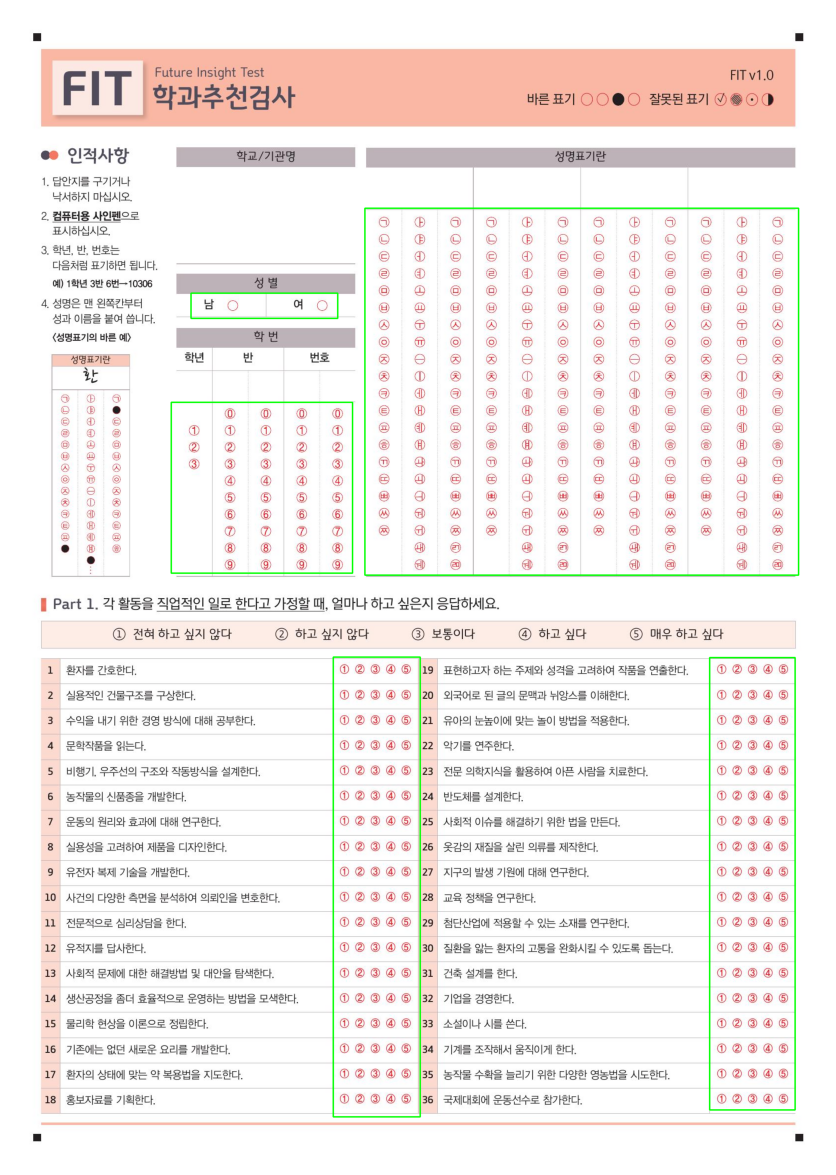

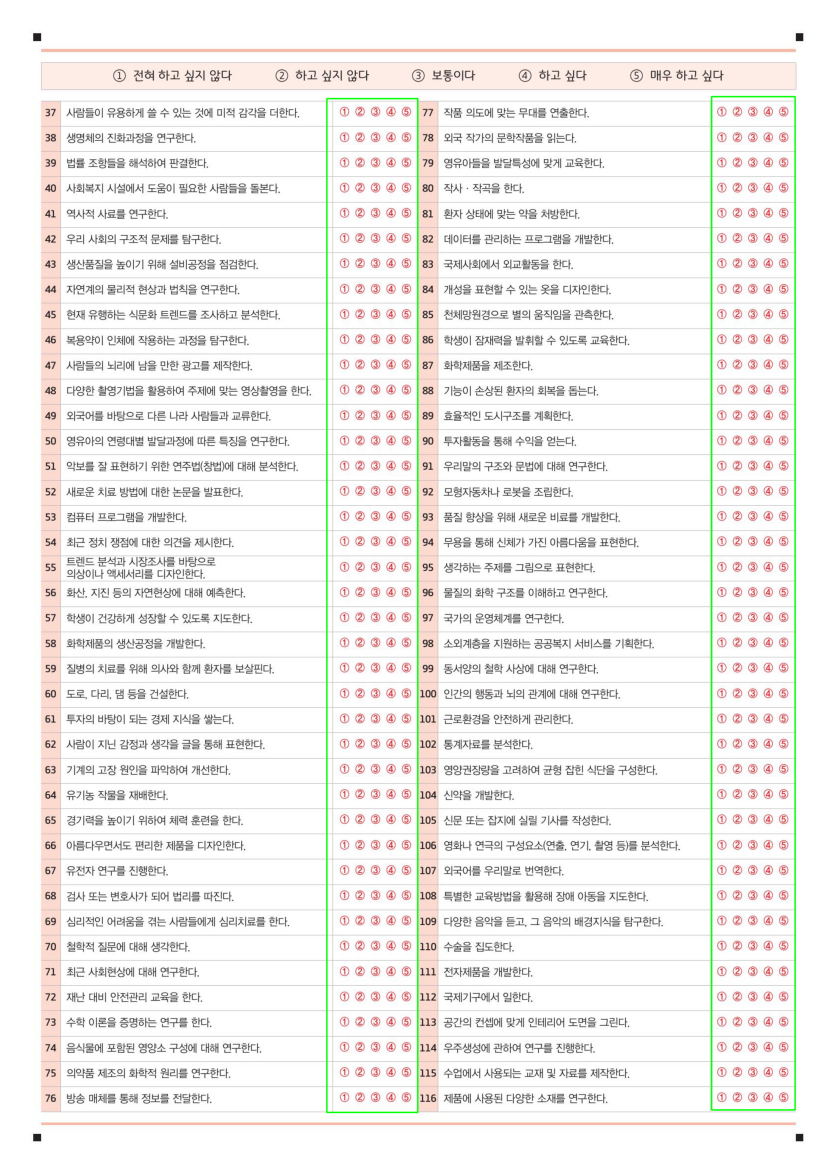

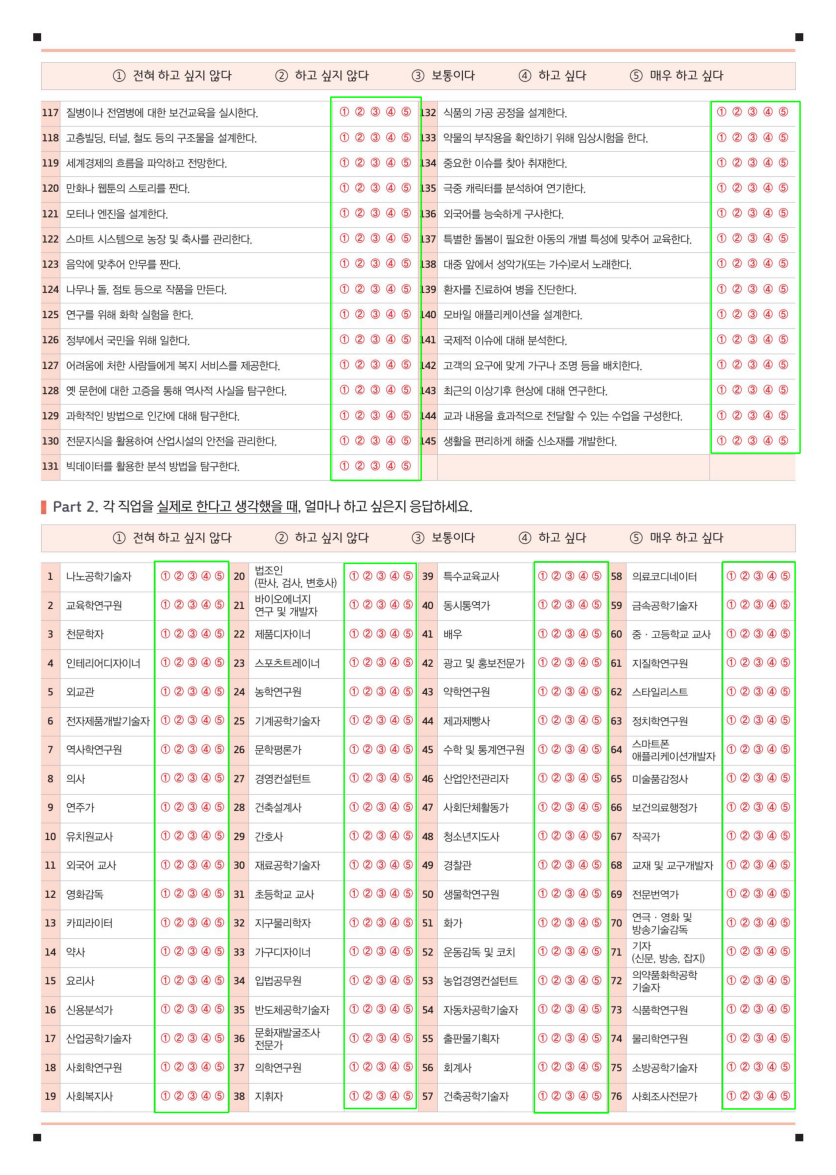

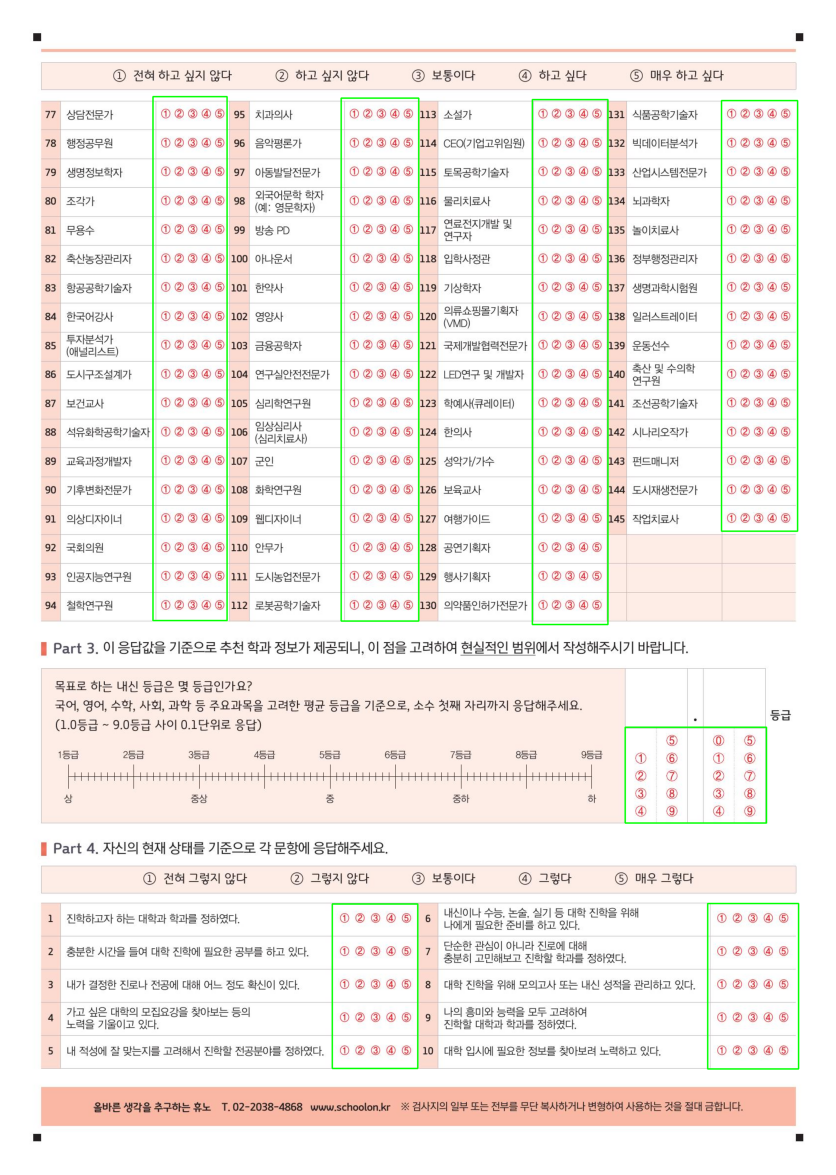

In [509]:
image_folder = './scan/datas/pdf/divided/tem'
for filename in os.listdir(image_folder):
    if (filename.endswith('.jpg')) and ("_page" not in filename) and ("FIT" in filename):
        cut_img_dict[filename] = []
        image_path = os.path.join(image_folder, filename)
        img = cv2.imread(image_path)
        num = int(filename.replace(".jpg", "")[-1])
        for x,y,xw,yh,_,_,_ in asd[num]:
            start_point = (x,y)
            end_point = (xw,yh)
            color = (0, 255, 0)  # 사각형 색상 (B, G, R) 형식
            thickness = 2  # 사각형 선 두께
            cv2.rectangle(img, start_point, end_point, color, thickness)
        plt.figure(figsize=(15, 15))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

In [510]:
#### 최신버전2
def is_in_sector(cnt, project_name, page, circle_point_dict):
    x, y, radius = cnt
    page = int(page)
    
    circle_left = x - radius
    circle_top = y - radius
    circle_right = x + radius
    circle_bottom = y + radius
    
    # 원이 사각형 내부에 완전히 포함되는지 확인
    pass_point = False
    for rdx, rect_point in enumerate(rects_point_dict[project_name][page]):
        sector = rdx+1
        left, top, right, bottom, t, part, start = rect_point
        # if isinstance(t,list):
        #     t = 2
        if (circle_left >= left and
            circle_top >= top and
            circle_right <= right and
            circle_bottom <= bottom):
            pass_point = True
            if project_name not in circle_point_dict:
                circle_point_dict[project_name] = {}
            if page not in circle_point_dict[project_name]:
                circle_point_dict[project_name][page] = {}
            if sector not in circle_point_dict[project_name][page]:
                circle_point_dict[project_name][page][sector] = []

            circle_point_dict[project_name][page][sector].append([int(x), int(y), int(radius), t, part, start])
            break
        
    if not pass_point:
        return False
    
    return True
    

def draw_contours(image_folder, output_folder): # 여기는 문제 없음
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    circle_point_dict = dict()
    for filename in os.listdir(image_folder):
        if (filename.endswith('.jpg')) and ("_page" not in filename):
            if ("CLS_검사지(중고등)" not in filename) and ("FIT" not in filename) and ("MIT" not in filename):
            # if ("FIT" not in filename):
                continue
            print(filename)
            project_name_page = filename.replace('.jpg', '')
            splited_project_name_page = project_name_page.split('_')
            project_name = "_".join(splited_project_name_page[:-1])
            page = splited_project_name_page[-1]
            
            image_path = os.path.join(image_folder, filename)
            image = cv2.imread(image_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # 가우시안 블러로 노이즈 감소
            gray = cv2.GaussianBlur(gray, (9, 9), 0)

            # HoughCircles 함수를 사용하여 원 검출
            if ("CLS_검사지(중고등)" in filename) or ("FIT" in filename):
                all_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.0, minDist=20,
                                        param1=50, param2=20, minRadius=9, maxRadius=12)
            
            if ("MIT" in filename):
                all_circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.0, minDist=20,
                                        param1=50, param2=25, minRadius=8, maxRadius=13)
            # all_circles = all_circles.astype(int)
            # circles = [(x,y,10) for cnt_list in all_circles for (x,y,r) in cnt_list if is_in_sector((x,y,r), project_name, page, circle_point_dict)]
            if all_circles is not None:
                all_circles = np.round(all_circles[0, :]).astype("int")
                circles = [(x, y, 10) for x, y, r in all_circles if is_in_sector((x, y, r), project_name, page, circle_point_dict)]
            
            # 원이 검출되었는지 확인
            # print(filename)
            # print(len(circles))
            if circles is not None:
                for (x, y, r) in circles:
                    cv2.circle(image, (x, y), r, (255, 0, 0), 2)
                    # # 중심점 그리기
                    # cv2.circle(image, (x, y), 2, (0, 0, 255), 3)

            # 결과 이미지 저장
            # result_image_path = os.path.join(output_folder, f"circles_{filename}")
            result_image_path = os.path.join(output_folder, f"{filename}")
            cv2.imwrite(result_image_path, image)
            # plt.figure(figsize=(20, 20))
            # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            # plt.axis('off')
            # plt.show()
    return circle_point_dict

image_output_folder = './scan/datas/pdf/square/tem' 
contour_output_folder = './scan/datas/pdf/circles/tem'  # 동그라미 검출 이미지를 저장할 폴더 경로

# 이미지에서 윤곽선 검출 및 그리기
circle_point_dict = draw_contours(image_output_folder, contour_output_folder)
circle_point_dict = {k: v for k, v in sorted(circle_point_dict.items())}
circle_point_dict = {k: {sk: sv for sk, sv in sorted(v.items())} for k, v in circle_point_dict.items()}
circle_point_dict = {k: {sk: {ssk: ssv for ssk, ssv in sorted(sv.items())} for sk, sv in v.items()} for k, v in circle_point_dict.items()}

CLS_검사지(중고등)_1.jpg
CLS_검사지(중고등)_2.jpg
CLS_검사지(중고등)_3.jpg
CLS_검사지(중고등)_4.jpg
FIT_1.jpg
FIT_2.jpg
FIT_3.jpg
FIT_4.jpg
MIT(고등)_1.jpg
MIT(고등)_2.jpg
MIT(고등)_3.jpg
MIT(고등)_4.jpg


In [511]:
circle_point_dict

{'CLS_검사지(중고등)': {1: {1: [[598, 454, 11, [0, 2, 2], 'schl', ['중학교', '남']],
    [388, 570, 11, [0, 2, 2], 'schl', ['중학교', '남']],
    [404, 454, 11, [0, 2, 2], 'schl', ['중학교', '남']],
    [570, 570, 11, [0, 2, 2], 'schl', ['중학교', '남']]],
   2: [[454, 914, 11, [4, '0.00.00'], '', [1]],
    [308, 880, 11, [4, '0.00.00'], '', [1]],
    [454, 812, 11, [4, '0.00.00'], '', [1]],
    [454, 1050, 11, [4, '0.00.00'], '', [1]],
    [602, 880, 11, [4, '0.00.00'], '', [1]],
    [602, 914, 11, [4, '0.00.00'], '', [1]],
    [454, 948, 11, [4, '0.00.00'], '', [1]],
    [602, 812, 11, [4, '0.00.00'], '', [1]],
    [454, 778, 11, [4, '0.00.00'], '', [1]],
    [454, 880, 11, [4, '0.00.00'], '', [1]],
    [602, 982, 11, [4, '0.00.00'], '', [1]],
    [602, 846, 11, [4, '0.00.00'], '', [1]],
    [602, 1016, 11, [4, '0.00.00'], '', [1]],
    [308, 846, 11, [4, '0.00.00'], '', [1]],
    [454, 982, 11, [4, '0.00.00'], '', [1]],
    [454, 1084, 11, [4, '0.00.00'], '', [1]],
    [528, 914, 11, [4, '0.00.00'], '', 

In [512]:
#### 최신
# def make_question_and_choice(c_df, type_):
def make_question_and_choice(s_df):
    # display(s_df)
    
    type_list = s_df['type'].values[0]
    start_list = s_df['start'].values[0]
    print(start_list)
    type_, select_cnt = type_list[0], type_list[1:]
    if type_ == 0:              # 가로형
        sort_col = 'y'
        sort_row = 'x'
    # if type_ == 1:              # 세로형
    if type_ in [1,3,4]:              # 세로형 이름형 숫자결합형
        sort_col = 'x'
        sort_row = 'y'
    if type_ == 5: # 가로-혼합형
        sort_col = 'y'
        sort_row = 'x'
    if type_ == 6: # 세로-혼합형
        sort_col = 'x'
        sort_row = 'y'

    c_df = s_df.sort_values(by=sort_col)
    col_current = c_df[sort_col].values[0]
    col_question_num_list = []
    col_chk_equal_question_num = [1]
    col_list = c_df[sort_col][1:]
    
    q_c_df = pd.DataFrame()
    for cdx, col in enumerate(col_list):
        if (abs(col_current - col) > 20) or (cdx == len(col_list)-1):
            col_question_num_list += col_chk_equal_question_num
            col_chk_equal_question_num = [col_chk_equal_question_num[-1]+1]
        else:
            col_chk_equal_question_num += [col_chk_equal_question_num[0]]
        col_current = col
    c_df['question_num'] = col_question_num_list + [col_question_num_list[-1]]
    
    for ddx, small_df in c_df.groupby(['page', 'sector', 'question_num']):
        small_df = small_df.sort_values(sort_row).reset_index(drop=True)
        small_df['choices_count'] = [i+1 for i in range(len(small_df))]
        q_c_df = pd.concat([q_c_df, small_df], axis=0)
    
    if type_ not in [3,4]:
        if len(select_cnt) >= 1:
            q_list, c_list = [], []
            max_q_num = [i for i in range(1, len(select_cnt)+1)]
            for i, j in zip(max_q_num, select_cnt):
                for j_j in range(j):
                    q_list.append(i)
                    c_list.append(j_j+1)
            q_c_df['question_num'] = q_list
            q_c_df['choices_count'] = c_list
    q_c_df['type'] = type_
    
    q_c_df['real_num'] = 0
    real_num_list = []
    start_schl_list = ['초', '중', '고', '대']
    start_gender_list = ['남', '여']
    for qdx, small_df in q_c_df.groupby(['page', 'sector', 'question_num']):
        if len(start_list) > 1:
            st_value = start_list[qdx[-1]-1] # 중학교, 남자
        else:
            st_value = start_list[0] # 중학교, 남자
            
        if isinstance(st_value, str):
            for start_schl in start_schl_list: # 초 중 고 대
                if start_schl in st_value:
                    st_schl_index = start_schl_list.index(start_schl)
                    real_num_list += start_schl_list[st_schl_index:len(small_df)+1]
            
            for sdx, start_gender in enumerate(start_gender_list):
                if start_gender in st_value:
                    if sdx == 0:
                        real_num_list += start_gender_list
                    else:
                        real_num_list += start_gender_list[::-1]
                        
        else:
            real_num_list += [i + st_value for i in range(len(small_df))]
            
    q_c_df['real_num'] = real_num_list    
    # display(q_c_df)
    return q_c_df

project_dict = dict()
for project_name, pages_dict in circle_point_dict.items():
    if ("CLS_검사지(중고등)" not in project_name) and ("FIT" not in project_name) and ("MIT" not in project_name):
        continue
    print(project_name)
    project_df = pd.DataFrame()
    for page, sector_dict in pages_dict.items():
        page_df = pd.DataFrame()
        for sector, circle_list in sector_dict.items():
            df = pd.DataFrame(circle_list, columns=['x', 'y', 'r', 'type', 'part', 'start'])
            df['page'] = page
            df['sector'] = sector
            df = df[['x', 'y', 'r', 'page', 'sector', 'type', 'part', 'start']]
            page_df = pd.concat([page_df, df], axis = 0).reset_index(drop=True)
        project_df = pd.concat([project_df, page_df], axis = 0).reset_index(drop=True)
        
    question_and_choice_df = pd.DataFrame()
    for idx, small_df in project_df.groupby(['page', 'sector']):
        grouped_question_and_choice_df = make_question_and_choice(small_df)
        question_and_choice_df = pd.concat([question_and_choice_df, grouped_question_and_choice_df], axis = 0).reset_index(drop = True)
        
    question_and_choice_df = question_and_choice_df.reset_index(drop = True)
    json_df = question_and_choice_df.to_json(orient='columns')
    project_dict[project_name] = json.loads(json_df)  

CLS_검사지(중고등)
['중학교', '남']
(1, 1, 1)
(1, 1, 2)
['중', '고', '남', '여']

[1]
(1, 2, 1)
(1, 2, 2)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
[1, 2, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

[1]
(1, 3, 1)
(1, 3, 2)
(1, 3, 3)
(1, 3, 4)
(1, 3, 5)
(1, 3, 6)
(1, 3, 7)
(1, 3, 8)
(1, 3, 9)
(1, 3, 10)
(1, 3, 11)
(1, 3, 12)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

In [579]:
with open('./scan/datas/json/rects_point_dict.json', 'w') as f:
    json.dump(rects_point_dict, f, ensure_ascii=False, indent=4)
    
with open('./scan/datas/json/circle_point_dict.json', 'w') as f:
    json.dump(circle_point_dict, f, ensure_ascii=False, indent=4)
    
with open('./scan/datas/json/project_dict.json', 'w') as f:
    json.dump(project_dict, f, ensure_ascii=False, indent=4)

---

In [549]:
asd = pd.DataFrame(project_dict['MIT(고등)'])

In [578]:
p = 4
s = 7

asd.loc[(asd['page'] == p) & (asd['sector'] == s)]

x     y   r  page  sector  type   part start  question_num  \
1917   286  1966  12     4       7     0  part5   [1]             1   
1918   330  1966  12     4       7     0  part5   [1]             1   
1919   374  1966  12     4       7     0  part5   [1]             1   
1920   418  1966  12     4       7     0  part5   [1]             1   
1921   464  1966  12     4       7     0  part5   [1]             1   
...    ...   ...  ..   ...     ...   ...    ...   ...           ...   
1999  1346  2074  12     4       7     0  part5   [1]             3   
2000  1390  2074  12     4       7     0  part5   [1]             3   
2001  1434  2074  12     4       7     0  part5   [1]             3   
2002  1478  2074  12     4       7     0  part5   [1]             3   
2003  1522  2074  12     4       7     0  part5   [1]             3   

      choices_count real_num  
1917              1        1  
1918              2        2  
1919              3        3  
1920              4        4  
1921              5        5  
...             ...      ...  
1999             25       25  
2000             26       26  
2001             27       27  
2002             28       28  
2003             29       29  

[87 rows x 11 columns]